# ** Описание **

Построить графики распределения в спам и не спам множествах следующих признаков:

1	Количество слов на странице
2	Средняя длинна слова
3	Количество слов в заголовке страниц (слова в теге <html><head><title> Some text </title>)
4	Количество слов в анкорах ссылок (<html><body><a> Some text </a>)
5	Коэффициент сжатия

Нужно посчитать статистику минимум по трем признакам и обязательно сделать для 1-го и 2-го признаков

И отправить первое решение в соревнование https://www.kaggle.com/c/antispam-information-retrieval/
На основании одного из указанных выше признаков попытаться разделить мн-во, так чтобы score в соревновании был больше 0.55

При выполнении всех этих условия в течении семинара +1 балл к ДЗ

Описание ДЗ и правил выставления за него баллов в https://www.kaggle.com/c/antispam-information-retrieval/  
Сроки ДЗ уточнить у преподователя - обычно 2 недели

In [33]:
from __future__ import division

import base64
import csv
import gzip
import zlib

from collections import namedtuple

%matplotlib inline
import matplotlib.pyplot as plt

In [34]:
TRACE_NUM = 1000
import logging
import importlib
importlib.reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

def trace(items_num, trace_num=TRACE_NUM):
    if items_num % trace_num == 0: logging.info("Complete items %05d" % items_num)
        
def trace_worker(items_num, worker_id, trace_num=TRACE_NUM):
    if items_num % trace_num == 0: logging.info("Complete items %05d in worker_id %d" % (items_num, worker_id))

### Утилиты

#### Декораторы

In [35]:
# def to_utf8(text):
#     if isinstance(text, unicode): text = text.encode('utf8')
#     return text

# def convert2unicode(f):
#     def tmp(text):
#         if not isinstance(text, unicode): text = text.decode('utf8')
#         return f(text)
#     return tmp

# def convert2lower(f):
#     def tmp(text):        
#         return f(text.lower())
#     return tmp

# #P.S. Декораторы могут усложнять отладку, так что от них вполне можно отказаться и воспользоваться copy-paste

### Извлечение текста из html

#### Извлечение текста при помощи встроенных модулей

In [36]:
from html.parser import HTMLParser
import re

###Извлечение текста из title можно вписать сюда

class TextHTMLParser(HTMLParser):
    def __init__(self):
        HTMLParser.__init__(self)
        self._text = []
        self._title = ""
        self._in_title = False

    def handle_data(self, data):
        text = data.strip()
        if len(text) > 0:
            text = re.sub('[ \t\r\n]+', ' ', text)
            self._text.append(text + ' ')

    def handle_starttag(self, tag, attrs):
        if tag == 'p':
            self._text.append('\n\n')
        elif tag == 'br':
            self._text.append('\n')
        elif tag == 'title':
            self._in_title = True

    def handle_startendtag(self, tag, attrs):
        if tag == 'br':
            self._text.append('\n\n')

    def text(self):
        return ''.join(self._text).strip()

def html2text_parser(text):
    parser = TextHTMLParser()
    parser.feed(text)
    return parser.text()

#### Извлечение текста при помощи дополнительных библиотек

In [37]:
def html2text_bs(raw_html):
    from bs4 import BeautifulSoup
    """
    Тут производится извлечения из html текста
    """
    soup = BeautifulSoup(raw_html, "html.parser")
    [s.extract() for s in soup(['script', 'style'])]
    return soup.get_text()

def html2text_bs_visible(raw_html):
    from bs4 import BeautifulSoup
    """
    Тут производится извлечения из html текста, который видим пользователю
    """
    soup = BeautifulSoup(raw_html, "html.parser")    
    [s.extract() for s in soup(['style', 'script', '[document]', 'head', 'title'])]
    return soup.get_text()


def html2text_bs_title(raw_html):
    from bs4 import BeautifulSoup
    """
    Тут производится извлечения из html - title
    """
    soup = BeautifulSoup(raw_html, "html.parser")    
    [s.extract() for s in soup(['title'])]
    return soup.get_text()


def html2text_bs_anchors(html_data):
    from bs4 import BeautifulSoup
    """
    Тут производится извлечения из html - title
    """
    soup = BeautifulSoup(raw_html, "html.parser")    
    [s.extract() for s in soup(['a'])]
    return soup.get_text()


def html2text_boilerpipe(raw_html):
    import boilerpipe
    """
    еще одна библиотека очень хорошо извлекающая именно видимый пользователю текст,
    но она завязана на java
    """
    pass

#### Выбираем какой метод для конвертации html в текст будет основным

In [38]:
#html2text = html2text_bs
html2text = html2text_parser

#### Методы для токенизации текста

In [39]:
def easy_tokenizer(text):
    
    word = str()
    for symbol in text:
        if symbol.isalnum(): word += symbol
        elif word:
            yield word
            word = str()
    if word: yield word


def my_tokenizer(text):
    return re.findall(r'\w+', text)
        
        
PYMORPHY_CACHE = {}
MORPH = None
#hint, чтобы установка pymorphy2 не была бы обязательной

def get_lemmatizer():
    import pymorphy2
    global MORPH
    if MORPH is None: MORPH = pymorphy2.MorphAnalyzer()
    return MORPH

def pymorphy_tokenizer(text):
    global PYMORPHY_CACHE
    for word in easy_tokenizer(text):
        word_hash = hash(word)
        if word_hash not in PYMORPHY_CACHE:
            PYMORPHY_CACHE[word_hash] = get_lemmatizer().parse(word)[0].normal_form            
        yield PYMORPHY_CACHE[word_hash]

#### Основная функция, которая вызывается для преобразования html в список слов

In [40]:
def html2word(raw_html, to_text=html2text, tokenizer=easy_tokenizer):
    return tokenizer(to_text(raw_html).lower())

In [41]:
list(html2word('<p><br>KhuIUhkjnaksjd   alsjkdfn Uun </br>  uuu lya</p>'))

['khuiuhkjnaksjd', 'alsjkdfn', 'uun', 'uuu', 'lya']

#### Рассчет финальных метрик

In [42]:
def safe_divide(a, b):
    if a == 0: return 0.0
    elif b == 0: return 0.0
    else: return a/b

def calculate_metrics(predictions, threshold):    
    """
    Функция подсчета метрик
    Параметры
    predictions - ранки по документам
    threshold  - порог для метрик
    """
    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0
    for (url_id, mark, url, prediction) in predictions:        
        mark_predict = prediction > threshold

        if mark_predict:                     
            if mark_predict == mark: true_positive += 1
            else: false_positive += 1                    
        else:                     
            if  mark_predict == mark: true_negative += 1
            else: false_negative += 1

    class_prec  = safe_divide(true_positive, true_positive + false_positive)
    class_recall = safe_divide(true_positive, true_positive + false_negative)
        
    class_F1 = safe_divide(2 * class_prec * class_recall, class_prec + class_recall)
    
    
    not_class_prec = safe_divide(true_negative, true_negative + false_negative)
    not_class_recall = safe_divide(true_negative, true_negative + false_positive)
    
    not_class_F1 = safe_divide(2 * not_class_prec * not_class_recall, not_class_prec + not_class_recall)
    
    return ( (class_prec, class_recall, class_F1), (not_class_prec, not_class_recall, not_class_F1) )

def arange(start, stop, step):
    cur_value = start
    while True:
        if cur_value > stop: break
        yield cur_value
        cur_value += step

def plot_results(docs, min_threshold=-1, max_threshold=1, step=0.1, trace=False):
    x = []
    y_p = []
    y_n = []
    docs_predictions = classifier.predict_all(docs)
    for threshold in arange(min_threshold, max_threshold, step):
        r = calculate_metrics(docs_predictions, threshold)
        x.append(threshold)
        y_p.append(r[0])
        y_n.append(r[1])        
        if trace: 
            print('threshold %s' % threshold)
            print('\tclass_prec %s, class_recall %s, class_F1 %s' % r[0])
            print('\tnot_class_prec %s, not_class_recall %s, not_class_F1 %s' % r[1])
            print('\t\tMacroF1Mesure %s' % ((r[0][2] + r[1][2])/2))
    plot_stats(x, y_p, "Class Result")
    plot_stats(x, y_n, "Not class Result")    


def plot_stats(x, y, title):
    plt.figure(figsize=(10, 5))

    prec, = plt.plot( x, 
                     [k[0] for k in y], "r", label='Precision', 
                     linewidth=1)
    accur, = plt.plot( x, 
                      [k[1] for k in y], "b", label='Recall',
                      linewidth=1)
    f1, =    plt.plot( x, 
                      [k[2] for k in y], "g", label='F1',
                      linewidth=1)
    plt.grid(True)
    plt.legend(handles=[prec, accur, f1])
    plt.title(title)
    plt.show()

## TODO:
- добавить фичи из необходимого списка
- добавить фичи из презы
- написать SVM-классификатор
- добавить tfidf векторизацию -> nmf ->
    - добавить фичу OneClass SVM 
    - добавить фичу LOF

- использовать другой токенизатор
- написать Random Forest
- написать Boosting 
- написать наивного байесовского классификатора
- написать голосование

-  количество скриптов?

In [43]:
from random import randrange
import os

In [44]:
def get_avg_word_len(words):
    lens = list(map(len, words))
    return sum(lens) / len(lens)

def get_compression_level(html_data):
    num = str(randrange(1009))
    filename = ''.join('./tmp', num, '.gz')
    with gzip.open(filename, 'wb') as f:
        f.write(html_data)
    # os.stat(filename).st_size # TODO: не совсем честно, лучше прочитать и посчитать 
    with open(filename, 'rb') as f:
        return len(html_data) / len(f.read())
    
    print('get_compression_level: some problems')

In [18]:
def calc_features(url, html_data):
    words = list(html2word(html_data))
    title_words = list( html2word(html_data, to_text=html2text_bs_title) )
    anchors_words = list( html2word(html_data, to_text=html2text_bs_anchors) )
    
    words_num = len(words)
    avg_word_len = get_avg_word_len(words)
    title_words_num = len(title_words)
    anchor_words_num = len(anchors_words)
    compression_level = get_compression_level(html_data)
    
    return [len(words), avg_word_len, title_words_num, anchor_words_num, compression_level]

In [19]:
test_html_data = u'''
<html>
<title> Заголовок Ololo </title>
спам 1 2 3
</html>
'''
test_url = 'http://ololo'
test_features = calc_features(test_url, test_html_data)
print(test_features)

[6, 0, 0, 0, 0]


In [ ]:
from tqdm.notebook import tqdm

In [21]:
from multiprocessing import Process, Queue, Lock

DocItem = namedtuple('DocItem', ['doc_id', 'is_spam', 'url', 'features'])

WORKER_NUM = 4

def load_csv(input_file_name, calc_features_f):    
    """
    Загружаем данные и извлекаем на лету признаки
    Сам контент не сохраняется, чтобы уменьшить потребление памяти - чтобы
    можно было запускать даже на ноутбуках в классе
    """
    global LAST_HTML
    with gzip.open(input_file_name, mode='rt', encoding='utf8') if input_file_name.endswith('gz') else open(input_file_name, mode='rt', encoding='utf8')  as input_file:            
        headers = input_file.readline()
        
        for i, line in enumerate(input_file):
            trace(i)
            parts = line.strip().split('\t')
            url_id = int(parts[0])                                        
            mark = bool(int(parts[1]))                    
            url = parts[2]
            pageInb64 = parts[3]
            html_data = base64.b64decode(pageInb64)
            try:
                html_data = html_data.decode('utf8')
            except:
                html_data = html_data.decode('latin1')
            features = calc_features_f(url, html_data)            
            yield DocItem(url_id, mark, url, features)            
                
        trace(i, 1)  
        
def load_csv_worker(input_file_name, calc_features_f, worker_id, res_queue):    
    with gzip.open(input_file_name,  mode='rt', encoding='utf8') if input_file_name.endswith('gz') else open(input_file_name, mode='rt', encoding='utf8')  as input_file:            
        headers = input_file.readline()
        
        for i, line in tqdm(enumerate(input_file)):
            trace_worker(i, worker_id)
            if i % WORKER_NUM != worker_id: continue
            parts = line.strip().split('\t')
            url_id = int(parts[0])                                        
            mark = bool(int(parts[1]))                    
            url = parts[2]
            pageInb64 = parts[3]
            html_data = base64.b64decode(pageInb64)
            try:
                html_data = html_data.decode('utf8')
            except:
                html_data = html_data.decode('latin1')
            features = calc_features_f(url, html_data)            
            res_queue.put(DocItem(url_id, mark, url, features))
                
        trace_worker(i, worker_id, 1)  
    res_queue.put(None)


def load_csv_multiprocess(input_file_name, calc_features_f):
    processes = []
    res_queue = Queue()
    
    for i in range(WORKER_NUM):
        process = Process(target=load_csv_worker, args=(input_file_name, calc_features_f, i, res_queue))
        processes.append(process)
        process.start()
    
    complete_workers = 0
    while complete_workers != WORKER_NUM:
        item = res_queue.get()
        if item is None:
            complete_workers += 1
        else:
            yield item
        
    for process in processes: process.join()

** Обрабатываем входной файл **
<br>
Формат - поля разделенные табуляциями
<br>
0 - идентификатор документа
<br>
1 - метка класса 0 - не спам, 1 - спам
<br>
2 - урл документа
<br>
3 - документ в кодировке base64

Выходной формат - массив кортежей вида
(doc_id, is_spam, url, html_data)

## Сбор данных

In [ ]:
%%time

TRAIN_DATA_FILE  = 'kaggle_train_data_tab.csv'
# TRAIN_DATA_FILE  = 'kaggle_train_data_tab.csv.gz'

train_docs = list(load_csv_multiprocess(TRAIN_DATA_FILE, calc_features))
# train_docs = list(load_csv(TRAIN_DATA_FILE, calc_features))
# ololo = load_csv(TRAIN_DATA_FILE, calc_features)

In [ ]:
len(train_docs)

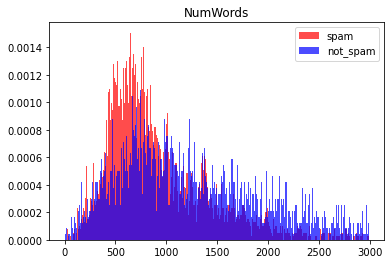

In [15]:
is_spam_data = [doc.features[0] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[0] for doc in train_docs if doc[1] == False]
bins = range(0,3000,10)
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('NumWords')
plt.legend()
plt.show()

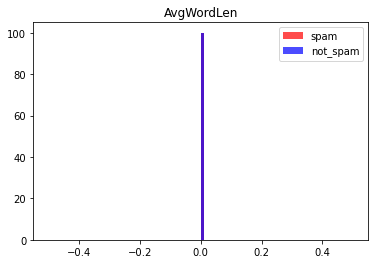

In [16]:
is_spam_data = [doc.features[1] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[1] for doc in train_docs if doc[1] == False]
bins = 100
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('AvgWordLen')
plt.legend()
plt.show()

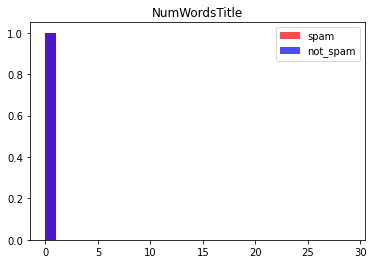

In [17]:
is_spam_data = [doc.features[2] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[2] for doc in train_docs if doc[1] == False]
bins = range(0, 30, 1)
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('NumWordsTitle')
plt.legend()
plt.show()

In [18]:
#Добавить графики для остальных фичей

** Классификатор: **
Нужно реализовать

In [19]:
class Classifier:
    
    def __init__(self):
        pass

    def predict(self, doc):        
        return doc.features[0]                     
    
    def predict_all(self, docs):
        res = []
        for doc_num, doc in enumerate(docs):
            trace(doc_num)
            prediction = self.predict(doc)            
            res.append( (doc.doc_id, doc.is_spam, doc.url, prediction) )
        return res
    
    def train(self, docs):                
        for doc_num, doc in enumerate(docs):                            
            #TODO вставить код обучения
            trace(doc_num)
        trace(doc_num, 1)

In [20]:
classifier = Classifier()
classifier.train(train_docs)

20:36:56 INFO:Complete items 00000
20:36:56 INFO:Complete items 01000
20:36:56 INFO:Complete items 02000
20:36:56 INFO:Complete items 03000
20:36:56 INFO:Complete items 04000
20:36:56 INFO:Complete items 05000
20:36:56 INFO:Complete items 06000
20:36:56 INFO:Complete items 07000
20:36:56 INFO:Complete items 07043


In [21]:
#Посмотреть, что предсказывается для тестового html
classifier.predict(DocItem(0, 0, test_url , test_features))

6

** Рисуем графики **

20:36:56 INFO:Complete items 00000
20:36:56 INFO:Complete items 01000
20:36:56 INFO:Complete items 02000
20:36:56 INFO:Complete items 03000
20:36:56 INFO:Complete items 04000
20:36:56 INFO:Complete items 05000
20:36:56 INFO:Complete items 06000
20:36:56 INFO:Complete items 07000


threshold 0
	class_prec 0.5833333333333334, class_recall 1.0, class_F1 0.7368421052631579
	not_class_prec 0.0, not_class_recall 0.0, not_class_F1 0.0
		MacroF1Mesure 0.3684210526315789
threshold 100
	class_prec 0.5840695354801938, class_recall 0.9975663178388903, class_F1 0.7367664240136604
	not_class_prec 0.6153846153846154, not_class_recall 0.00545144804088586, not_class_F1 0.010807159743329955
		MacroF1Mesure 0.3737867918784952
threshold 200
	class_prec 0.5845487364620938, class_recall 0.9851545388172305, class_F1 0.7337321007794091
	not_class_prec 0.48739495798319327, not_class_recall 0.019761499148211244, not_class_F1 0.03798297314996726
		MacroF1Mesure 0.38585753696468816
threshold 300
	class_prec 0.582345971563981, class_recall 0.9569238257483572, class_F1 0.7240585581438173
	not_class_prec 0.3938356164383562, not_class_recall 0.039182282793867124, not_class_F1 0.07127362875735978
		MacroF1Mesure 0.3976660934505885
threshold 400
	class_prec 0.5810331534309946, class_recall 0.917

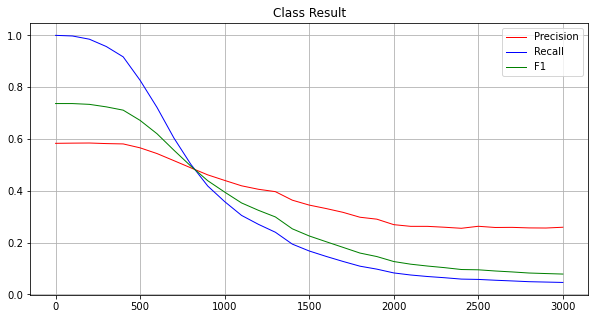

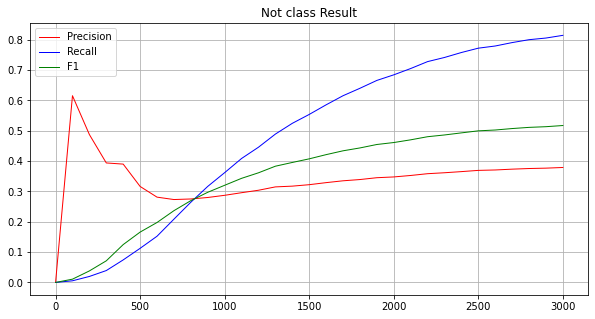

In [22]:
plot_results(train_docs, min_threshold=0, max_threshold=3000, step=100, trace=1)

In [23]:
%%time

TEST_DATA_FILE  = 'kaggle_test_data_tab.csv'
# TEST_DATA_FILE  = 'kaggle_test_data_tab.csv.gz'

test_docs = load_csv_multiprocess(TEST_DATA_FILE, calc_features)

threshold = 800

with open('my_submission.csv' , 'wt') as fout:
    writer = csv.writer(fout)
    writer.writerow(['Id','Prediction'])
    for item in classifier.predict_all(test_docs):
        prediction =  1 if item[3] > threshold else 0
        writer.writerow([item[0], prediction])

20:36:57 INFO:Complete items 00000 in worker_id 0
20:36:57 INFO:Complete items 00000 in worker_id 1
20:36:57 INFO:Complete items 00000 in worker_id 2
20:36:57 INFO:Complete items 00000
20:36:57 INFO:Complete items 00000 in worker_id 3
20:37:07 INFO:Complete items 01000 in worker_id 2
20:37:07 INFO:Complete items 01000 in worker_id 1
20:37:08 INFO:Complete items 01000
20:37:10 INFO:Complete items 01000 in worker_id 3
20:37:13 INFO:Complete items 01000 in worker_id 0
20:37:15 INFO:Complete items 02000 in worker_id 1
20:37:15 INFO:Complete items 02000 in worker_id 2
20:37:20 INFO:Complete items 02000
20:37:23 INFO:Complete items 02000 in worker_id 0
20:37:23 INFO:Complete items 02000 in worker_id 3
20:37:24 INFO:Complete items 03000 in worker_id 2
20:37:25 INFO:Complete items 03000 in worker_id 1
20:37:28 INFO:Complete items 03000
20:37:30 INFO:Complete items 03000 in worker_id 3
20:37:32 INFO:Complete items 04000 in worker_id 2
20:37:32 INFO:Complete items 03000 in worker_id 0
20:37:33 I

CPU times: user 1.1 s, sys: 279 ms, total: 1.38 s
Wall time: 2min 33s
